In [1]:
import numpy as np
import matplotlib.pyplot as plt
from kymatio import Scattering2D
import nibabel as nib
import matplotlib.pyplot as plt
import scipy.ndimage  as ndimage
from sklearn.cluster import KMeans

In [4]:
# Load the NIfTI file
month1 = nib.load('anita_1.nii')
month1_data = month1.get_fdata()
month1_data = month1_data/np.max(month1_data)

month3 = nib.load('anita_3.nii')
month3_data = month3.get_fdata()
month3_data = month3_data/np.max(month3_data)

bone_mask_month_1 = nib.load('./saved-data/bone_mask_month_1.nii').get_fdata()
bone_mask_month_3 = nib.load('./saved-data/bone_mask_month_3.nii').get_fdata()

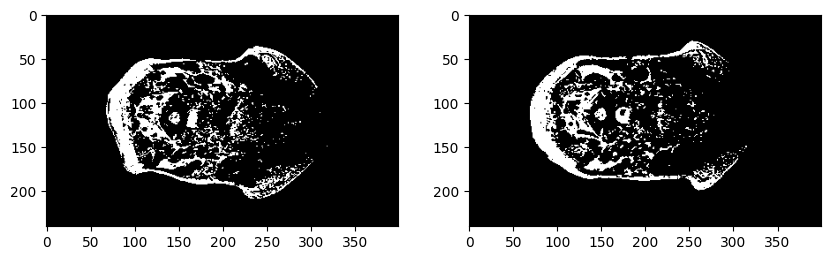

In [19]:
fig,ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(bone_mask_month_1[:,:,100], cmap='gray')
ax[1].imshow(bone_mask_month_3[:,:,100], cmap='gray')

In [20]:
masked_bone_month_1 = month1_data * bone_mask_month_1
masked_bone_month_3 = month3_data * bone_mask_month_3

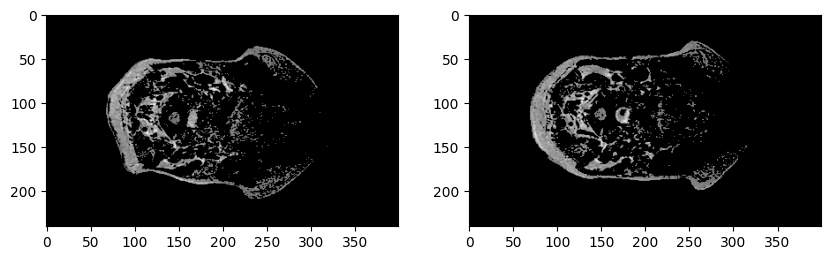

In [21]:
fig,ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(masked_bone_month_1[:,:,100], cmap='gray')
ax[1].imshow(masked_bone_month_3[:,:,100], cmap='gray')

In [23]:
import SimpleITK as sitk

# Function to convert numpy array to SimpleITK image
def numpy_to_sitk(image_np):
    return sitk.GetImageFromArray(image_np)

# Function to convert SimpleITK image to numpy array
def sitk_to_numpy(image_sitk):
    return sitk.GetArrayFromImage(image_sitk)

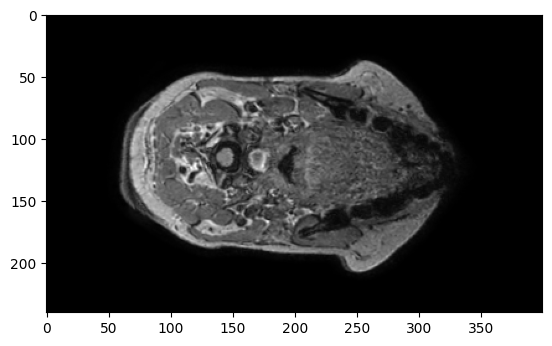

In [26]:
reference_image = numpy_to_sitk(masked_bone_month_1)
moving_image = numpy_to_sitk(masked_bone_month_3)


# Initialize the registration method
registration_method = sitk.ImageRegistrationMethod()

# Set metric, optimizer, and interpolator for the registration
registration_method.SetMetricAsMeanSquares()
registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100)
registration_method.SetInterpolator(sitk.sitkLinear)

# Set the initial transformation as a rigid transformation
initial_transform = sitk.CenteredTransformInitializer(reference_image,
                                                      moving_image,
                                                      sitk.Euler3DTransform(),
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)

registration_method.SetInitialTransform(initial_transform, inPlace=False)
final_transform = registration_method.Execute(reference_image, moving_image)

# Print out the final transform
# print("Final Transform:\n", final_transform)

# Apply the transformation to a different 3D matrix
new_moving_np = month3_data
new_reference_np = month1_data
new_reference_image = numpy_to_sitk(new_reference_np)
new_moving_image = numpy_to_sitk(new_moving_np)
transformed_image = sitk.Resample(new_moving_image, new_reference_image, final_transform, sitk.sitkLinear, 0.0, new_moving_image.GetPixelID())

# Convert the transformed image back to a numpy array
transformed_np = sitk_to_numpy(transformed_image)

# # Save the transformation to a file (optional)
# sitk.WriteTransform(final_transform, "rigid_transform.tfm")

# If you want to load and apply the saved transform
# loaded_transform = sitk.ReadTransform("rigid_transform.tfm")
# transformed_image_with_loaded_transform = sitk.Resample(new_moving_image, reference_image, loaded_transform, sitk.sitkLinear, 0.0, new_moving_image.GetPixelID())
# transformed_np_with_loaded_transform = sitk_to_numpy(transformed_image_with_loaded_transform)

# transformed_np now contains the transformed 3D matrix of the new input

plt.imshow(transformed_np[:,:,100], cmap='gray')

Text(0.5, 1.0, 'Month 3 Transformed to Month 1')

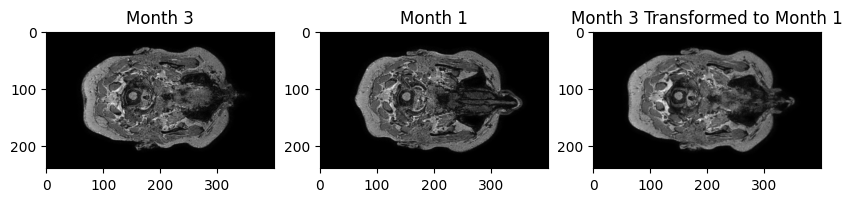

In [37]:
fig,ax = plt.subplots(1,3, figsize=(10,5))
idx = 143
ax[0].imshow(new_moving_np[:,:,idx], cmap='gray')
ax[0].set_title('Month 3')
ax[1].imshow(new_reference_np[:,:,idx], cmap='gray')
ax[1].set_title('Month 1')
ax[2].imshow(transformed_np[:,:,idx], cmap='gray')
ax[2].set_title('Month 3 Transformed to Month 1')

In [38]:
registered_month_3 = transformed_np

In [42]:
# find correlation bwteen month 1 and registered month 3
correlation = np.corrcoef(new_reference_np.flatten(), registered_month_3.flatten())[0,1]
print('Correlation between month 1 and registered month 3:', correlation)
# find correlation bwteen month 1 and month 3
correlation = np.corrcoef(new_reference_np.flatten(), new_moving_np.flatten())[0,1]
print('Correlation between month 1 and month 3 (original):', correlation)

Correlation between month 1 and registered month 3: 0.8253143870899942
Correlation between month 1 and month 3 (original): 0.7569567879685091


Correlation between month 1 and month 3: 0.7710995545510168
Correlation between month 1 and registered month 3: 0.8132974733510585


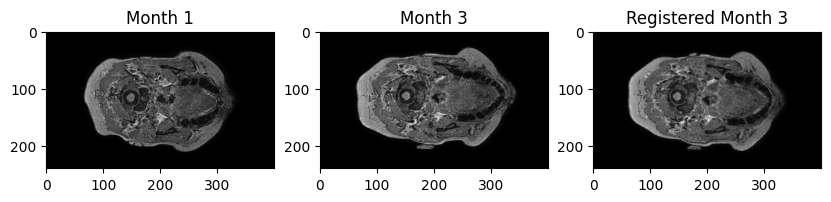

In [48]:
index = 120
month1img = new_reference_np[:,:,index]
month3img = new_moving_np[:,:,index]
registered_month3img = registered_month_3[:,:,index] 

fig,ax = plt.subplots(1,3, figsize=(10,5))
ax[0].imshow(month1img, cmap='gray')
ax[0].set_title('Month 1')
ax[1].imshow(month3img, cmap='gray')
ax[1].set_title('Month 3')
ax[2].imshow(registered_month3img, cmap='gray')
ax[2].set_title('Registered Month 3')

# correlation between images
correlation = np.corrcoef(month1img.flatten(), month3img.flatten())[0,1]
print('Correlation between month 1 and month 3:', correlation)
correlation = np.corrcoef(month1img.flatten(), registered_month3img.flatten())[0,1]
print('Correlation between month 1 and registered month 3:', correlation)

In [50]:
# Compute the scattering coefficients
scattering = Scattering2D(J=2, shape=month1img.shape)
scattering_month1 = scattering(month1img)
scattering_month3 = scattering(month3img)
scattering_registered_month3 = scattering(registered_month3img)

In [53]:
# compute correlation between scattering coefficients
normalized_scattering_month1 = scattering_month1/np.max(scattering_month1)
normalized_scattering_month3 = scattering_month3/np.max(scattering_month3)
normalized_scattering_registered_month3 = scattering_registered_month3/np.max(scattering_registered_month3)
threshold = 0.2
# thres

correlation = np.corrcoef(normalized_scattering_month1.flatten(), normalized_scattering_month3.flatten())[0,1]
print('Correlation between month 1 and month 3:', correlation)
correlation = np.corrcoef(normalized_scattering_month1.flatten(), normalized_scattering_registered_month3.flatten())[0,1]
print('Correlation between month 1 and registered month 3:', correlation)


Correlation between month 1 and month 3: 0.9000162696330142
Correlation between month 1 and registered month 3: 0.9214247127067683
